# Machine Learning Models for stock prediction - non transformation version

# Import necessary libraries

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

## Import data

The data was downloaded from Bloomberg on:
* Exchange rate of Vietnam with its major trading partners: the China and the US
* Precious metal spot price and future price: Gold, Silver, Palladium, Platinum
* Global Stock Indices: Hang Seng Index, Nasdaq 100, Nasdaq Composite, Nikkei 225, SP500, DOJI, Shanghai Shenzhen CSI3000, Shanghai Shenzhen Composite and Singapore Stock Index
* Volatility stock index: VIX Index

The data will be imported from previous EDA session, which has been cleaned.

In [130]:
# Import data
data = pd.read_csv('data.csv')

# Transfer date column to date time
import datetime
data['Date'] = pd.to_datetime(data['Date'], format = '%m/%d/%Y')

# Turn date into index
data.set_index('Date', inplace = True)

# Common features

We will generate the following set of features:
- Return of n lag days
- Lags price of n lag days
- Diff price of n lag days
- Generate log differencing data
- Other necessary train test split, metrics function

In [131]:
# Import metrics
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

def rmse(mse):
    rmse = np.sqrt(mse)

In [132]:
# Define evaluate model
def evaluate_model(model, X_train, y_train, X_cv, y_cv):
    # Fit model and obtain result
    model.fit(X_train, y_train)
    y_pred_cv = model.predict(X_cv)
    MAE = mae(y_cv, y_pred_cv)
    MSE = mse(y_cv, y_pred_cv)
    RMSE = rmse(MSE)

    # Store result
    return MAE, MSE, RMSE

In [133]:
# Generate lag function

def generate_lag(df, n_lags):
    """
    Generate n lag for each columns of the dataframe
    
    """
     # df_copy
    df2 = df.copy()
    
    # Create column list
    new_columns = []
    
    # Define n_lags:
    lag_range = range(1, n_lags + 1)
    
    # Generate new columns with lags
    for col in df2.columns:
        for i in lag_range:
            new_col_name = f"{col}_lag_{i}"
            df2[new_col_name] = df2[col].shift(periods = i)
            new_columns.append(new_col_name)
    
    return df2[new_columns]

In [134]:
# Generate return
def generate_return(df, n_lags):
    """
    Generate n lag return for each columns of the dataframe
    
    """
    # df_copy
    df2 = df.copy()
    
    # Create column list
    new_columns = []
    
    # Define lag range
    lag_range = range(1, n_lags + 1)
    
    # Generate new columns with lags
    for col in df2.columns:
        for i in lag_range:
            new_col_name = f"{col}_return_{i}"
            df2[new_col_name] = df2[col].pct_change(periods = i)
            new_columns.append(new_col_name)
    
    return df2[new_columns]

In [135]:
# Generate diff
def generate_diff(df, n_lags):
    """
    Generate n lag diff for each columns of the dataframe
    
    """
     # df_copy
    df2 = df.copy()
    
    # Create column list
    new_columns = []
    
    # Define n_lags:
    lag_range = range(1, n_lags + 1)
    
    # Generate new columns with lags
    for col in df2.columns:
        for i in lag_range:
            new_col_name = f"{col}_diff_{i}"
            df2[new_col_name] = df2[col].diff(periods = i)
            new_columns.append(new_col_name)
    
    return df2[new_columns]

In [136]:
# Define train test split
def train_test_split(df, target):
    # Define train, cv, test time
    train_time = int(round(len(df) * 0.7))
    cv_time = int(round(len(df) * 0.1))
    
    # Define X, y
    X = df.drop(target, axis = 1)
    y = df[target]
    
    # Train test split
    X_train = X.iloc[:train_time]
    X_cv = X.iloc[train_time : (train_time + cv_time)]
    X_test = X.iloc[(train_time + cv_time):]
    
    y_train = y.iloc[:train_time]
    y_cv = y.iloc[train_time : (train_time + cv_time)]
    y_test = y.iloc[(train_time + cv_time):]
    
    # Print out to check shape
    print(X_train.shape)
    print(X_cv.shape)
    print(X_test.shape)
    
    print(y_train.shape)
    print(y_cv.shape)
    print(y_test.shape)
    
    return X_train, y_train, X_cv, y_cv, X_test, y_test

In [137]:
# Define a function to transfer prediction into return
def generate_price(df, price_col, ret_pred_col):
    #Generate a data copy
    df2 = df.copy()
    
    # Create pred values
    pred_close = []
    
    # Generate new col:
    for i in range(len(df) - 1):
        pred_price = df2[price_col].iloc[i] * (df2[ret_pred_col].iloc[i+1])
        pred_close.append(pred_price)
    
    # Drop missing values
    df2 = df2.iloc[:-1]
    df2['Pred_Price'] = pred_close
    df2.dropna(inplace = True)
    
    return df2

## Prepare models

We will prepare regression models. We will fit on non-tuned models first to see the model, then based on the result, we will perform further hyperparameters tunning if needed

In [138]:
# Import model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

In [139]:
# Call out object
lr = LinearRegression()
ridge = Ridge(alpha = 15)
lasso = Lasso(alpha = 20)
dtr = DecisionTreeRegressor(criterion = 'squared_error', max_depth = 10, min_samples_split = 4)
gb = GradientBoostingRegressor()
xgb = XGBRegressor()
rf = RandomForestRegressor(criterion = 'squared_error', max_depth = 10, min_samples_split = 4)

# Set models list
models = [lr, ridge, lasso, dtr, gb, xgb, rf]

# Machine Learning - Log diff ver

We will perform the test on several models to determine which models will perform best. The models are:
- Linear Regression (include Ridge and Lasso for avoid multicolinearity)
- Decision Trees Regressor
- Gradient Boosting Regressor
- XGBoost Regressor
- Random Forest Regressor

## Generate log_diff version and EDA

In [140]:
# Generate log data
data_log = np.log(data)

# Generate diff
data_log_diff = data_log.diff()
data_log_diff.dropna(inplace = True)

# Check dataframe
data_log_diff.head()

,index_sp500,spot_palladium,index_shsz_csi300,index_vni
Date,,,,
2007-07-03,0.003574,-0.009543,0.000062,-0.017115
2007-07-04,-0.001759,0.002736,-0.000062,0.036430
2007-07-05,0.002107,-0.001367,0.000000,-0.000730
2007-07-06,0.003299,0.004096,0.000310,-0.002264
2007-07-09,0.000921,0.002721,-0.000062,-0.000257


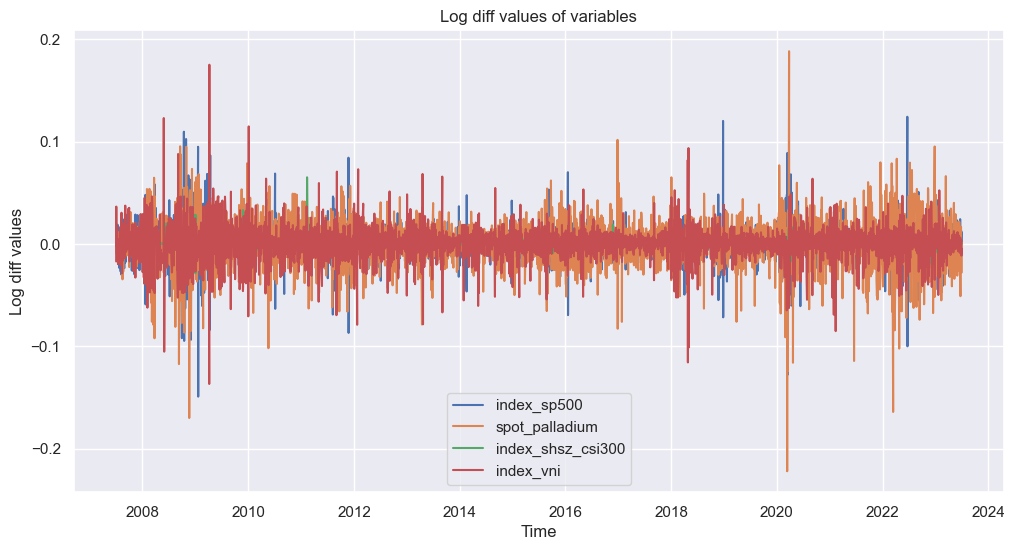

In [141]:
# Visualize the variables in dataframe
fix, ax = plt.subplots(figsize = (12,6))

for col in data_log_diff.columns:
    ax.plot(data_log_diff[col], label = f"{col}")
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Log diff values')
ax.set_title('Log diff values of variables')
plt.show()

In [142]:
# Check data descriptive statistics
data_log_diff.describe()

,index_sp500,spot_palladium,index_shsz_csi300,index_vni
count,4174.000000,4174.000000,4174.000000,4174.000000
mean,0.000257,0.000289,0.000091,0.000029
std,0.014997,0.021329,0.002260,0.016098
min,-0.149110,-0.221968,-0.028604,-0.136759
25%,-0.004942,-0.009946,-0.000269,-0.006354
50%,0.000669,0.001096,0.000000,0.000759
75%,0.006335,0.011891,0.000282,0.007499
max,0.124169,0.188134,0.065051,0.174953


## Test on different models

### Test on original log diff dataset

In [143]:
# Train test split the data
X_train, y_train, X_cv, y_cv, X_test, y_test = train_test_split(data_log_diff, 'index_vni')

(2922, 3)
(417, 3)
(835, 3)
(2922,)
(417,)
(835,)


In [144]:
# Test on different models
# Test with models with non-scaling features
col = ['Linear Regression','Ridge','Lasso','Decision Tree','Gradient Boosting','XGBoost','Random Forest']
MAE_cv = []
MSE_cv = []

for model in models:
    MAE, MSE, RMSE = evaluate_model(model, X_train, y_train, X_cv, y_cv)
    MAE_cv.append(round(MAE, 10))
    MSE_cv.append(round(MSE,10))

cv_result = pd.DataFrame(data = [MAE_cv, MSE_cv], columns = [col], index = ['MAE','MSE'])
cv_result.T.sort_values(by = 'MAE')

,MAE,MSE
Linear Regression,0.007101,0.000125
Ridge,0.007107,0.000127
Lasso,0.007111,0.000128
Random Forest,0.007383,0.000127
Gradient Boosting,0.007430,0.000135
Decision Tree,0.008466,0.000227
XGBoost,0.009093,0.000173


In [145]:
# Test on different models
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Test with models with non-scaled features on test set
col = ['Linear Regression','Ridge','Lasso','Decision Tree','Gradient Boosting','XGBoost','Random Forest']
MAE_cv = []
MSE_cv = []

for model in models:
    MAE, MSE, RMSE = evaluate_model(model, X_train, y_train, X_test, y_test)
    MAE_cv.append(round(MAE, 10))
    MSE_cv.append(round(MSE,10))

cv_result = pd.DataFrame(data = [MAE_cv, MSE_cv], columns = [col], index = ['MAE','MSE'])
cv_result.T.sort_values(by = 'MAE')

,MAE,MSE
Ridge,0.009847,0.000212
Lasso,0.009848,0.000212
Linear Regression,0.009907,0.000213
Random Forest,0.010167,0.000218
Gradient Boosting,0.010445,0.000229
Decision Tree,0.010996,0.000293
XGBoost,0.012019,0.000275


Linear regression model obtains the lowest error, along with Ridge and Lasso. Let's obtain the result and transfer them into real values. However, the values performed on test data generates significant error. We can further improve by try generating lags

In [146]:
# Refit the model
lr.fit(X_train, y_train)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

# Obtain the CV and test predictions
lr_pred_cv = lr.predict(X_cv)
lr_pred_test = lr.predict(X_test)

ridge_pred_cv = ridge.predict(X_cv)
ridge_pred_test = ridge.predict(X_test)

lasso_pred_cv = lasso.predict(X_cv)
lasso_pred_test = lasso.predict(X_test)

# Concatenate the 
lr_pred = np.concatenate([lr_pred_cv, lr_pred_test], axis = None)
ridge_pred = np.concatenate([ridge_pred_cv, ridge_pred_test], axis = None)
lasso_pred = np.concatenate([lasso_pred_cv, lasso_pred_test], axis = None)

In [147]:
# Inverse the prediction to real return
lr_pred = np.exp(lr_pred)
ridge_pred = np.exp(ridge_pred)
lasso_pred = np.exp(lasso_pred)

In [148]:
# Turn return into real price
train_time = int(round(len(data) * 0.7))

price_data = data[['index_vni']].iloc[train_time + 1:]
price_data['LR_pred'] = lr_pred
price_data['Ridge_pred'] = ridge_pred
price_data['Lasso_pred'] = lasso_pred

In [149]:
# Turn prediction in actual prices
lr_pred_price = generate_price(price_data, 'index_vni', 'LR_pred')
Ridge_pred_price = generate_price(price_data, 'index_vni', 'Ridge_pred')
Lasso_pred_price = generate_price(price_data, 'index_vni', 'Lasso_pred')

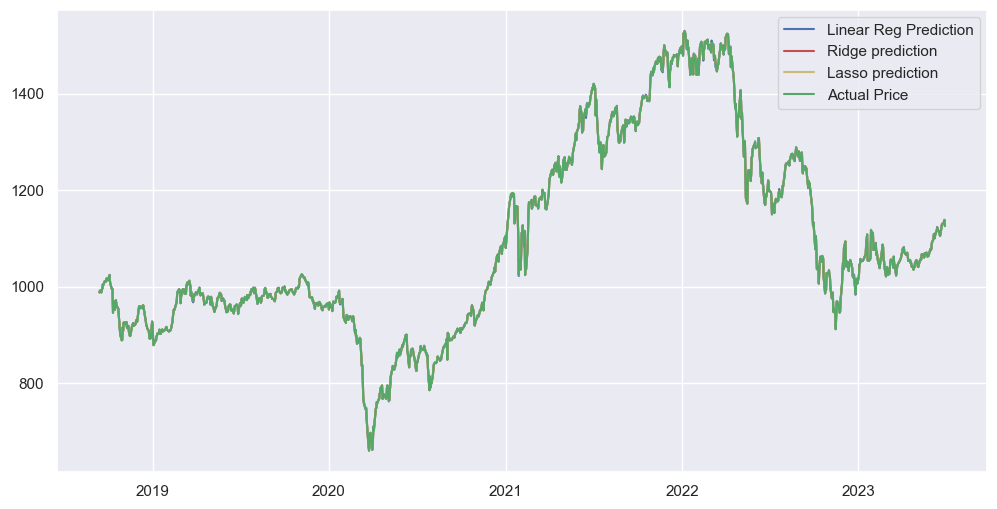

In [150]:
# Visualize prediction
fix, ax = plt.subplots(figsize = (12,6))

ax.plot(lr_pred_price['Pred_Price'], color = 'b', label = 'Linear Reg Prediction')
ax.plot(Ridge_pred_price['Pred_Price'], color = 'r', label = 'Ridge prediction')
ax.plot(Lasso_pred_price['Pred_Price'], color = 'y', label = 'Lasso prediction')
ax.plot(lr_pred_price['index_vni'], color = 'g', label = 'Actual Price')
ax.legend()
plt.show()

The model fits almost perfectly well if we build model based on log_diff price movement. But first, we will zoom in to see the actual prediction first.

In [151]:
# Zoom in 2023
start = datetime.datetime(2023,1,1)
end = datetime.datetime(2023,6,30)

# Get the slice
lr_prediction = lr_pred_price['Pred_Price'].loc[start:end]
lasso_prediction = Lasso_pred_price['Pred_Price'].loc[start:end]
ridge_prediction = Ridge_pred_price['Pred_Price'].loc[start:end]
actual_price = price_data['index_vni'].loc[start:end]

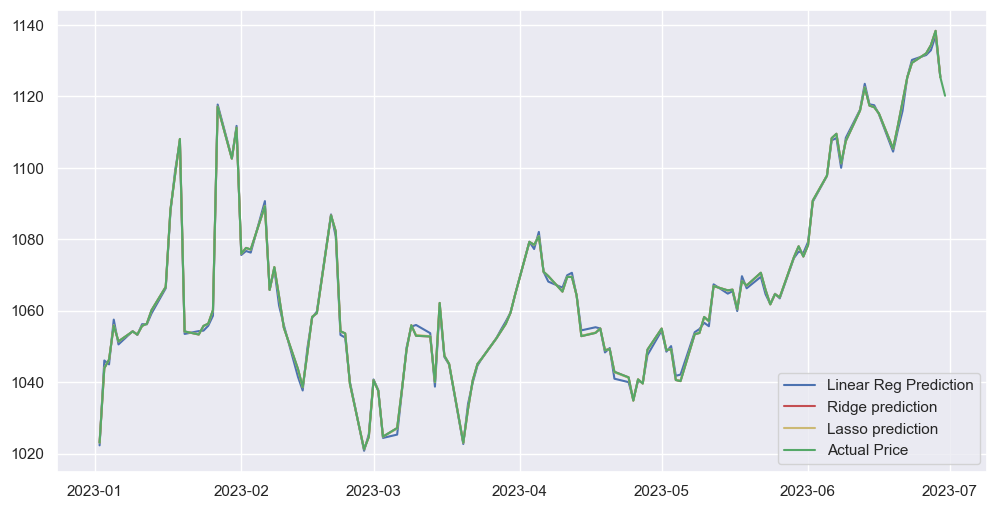

In [152]:
# Visualize
fix, ax = plt.subplots(figsize = (12,6))

ax.plot(lr_prediction, color = 'b', label = 'Linear Reg Prediction')
ax.plot(lasso_prediction, color = 'r', label = 'Ridge prediction')
ax.plot(ridge_prediction, color = 'y', label = 'Lasso prediction')
ax.plot(actual_price, color = 'g', label = 'Actual Price')
ax.legend()
plt.show()


Almost perfectly fitted! Again, this might be a problem of using log diff instead of log lag, as diff can reveals data into the future. We will test on log lag

# Machine Learning - Log lag ver

In [193]:
# Generate log lag - test with 5 lags
data_log_lag = generate_lag(data_log, 5)
data_log_lag = pd.concat([data_log, data_log_lag], axis = 1)
data_log_lag = data_log_lag.iloc[5:]
data_log_lag.head()

,index_sp500,spot_palladium,index_shsz_csi300,index_vni,index_sp500_lag_1,index_sp500_lag_2,index_sp500_lag_3,index_sp500_lag_4,index_sp500_lag_5,spot_palladium_lag_1,...,index_shsz_csi300_lag_1,index_shsz_csi300_lag_2,index_shsz_csi300_lag_3,index_shsz_csi300_lag_4,index_shsz_csi300_lag_5,index_vni_lag_1,index_vni_lag_2,index_vni_lag_3,index_vni_lag_4,index_vni_lag_5
Date,,,,,,,,,,,,,,,,,,,,,
2007-07-09,7.334231,5.908083,9.688684,6.917973,7.333311,7.330012,7.327905,7.329664,7.326091,5.905362,...,9.688746,9.688436,9.688436,9.688498,9.688436,6.918230,6.920494,6.921224,6.884794,6.901908
2007-07-10,7.319944,5.907539,9.688622,6.930534,7.334231,7.333311,7.330012,7.327905,7.329664,5.908083,...,9.688684,9.688746,9.688436,9.688436,9.688498,6.917973,6.918230,6.920494,6.921224,6.884794
2007-07-11,7.325649,5.909441,9.688560,6.937168,7.319944,7.334231,7.333311,7.330012,7.327905,5.907539,...,9.688622,9.688684,9.688746,9.688436,9.688436,6.930534,6.917973,6.918230,6.920494,6.921224
2007-07-12,7.344525,5.913503,9.688436,6.925281,7.325649,7.319944,7.334231,7.333311,7.330012,5.909441,...,9.688560,9.688622,9.688684,9.688746,9.688436,6.937168,6.930534,6.917973,6.918230,6.920494
2007-07-13,7.347622,5.908436,9.688436,6.923363,7.344525,7.325649,7.319944,7.334231,7.333311,5.913503,...,9.688436,9.688560,9.688622,9.688684,9.688746,6.925281,6.937168,6.930534,6.917973,6.918230


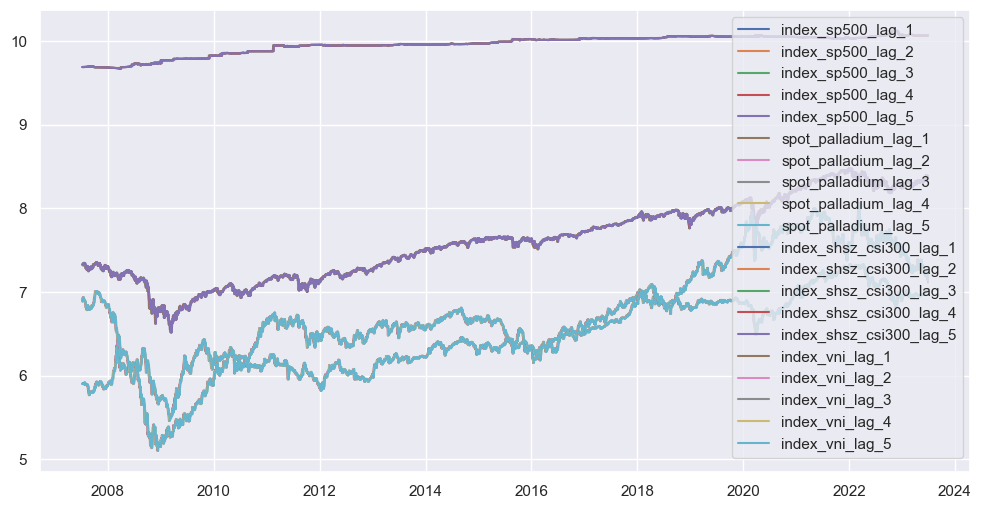

In [194]:
# Visualize the variables in dataframe
fix, ax = plt.subplots(figsize = (12,6))

for col in data_log_lag.iloc[:, 4:].columns:
    ax.plot(data_log_lag[col], label = f"{col}")
ax.legend()

In [195]:
# Train test split the data
X_train, y_train, X_cv, y_cv, X_test, y_test = train_test_split(data_log_lag, 'index_vni')

(2919, 23)
(417, 23)
(834, 23)
(2919,)
(417,)
(834,)


In [189]:
# Scaling the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit the data
X_train_scaled = scaler.fit_transform(X_train)
X_cv_scaled = scaler.transform(X_cv)
X_test_scaled = scaler.transform(X_test)

In [196]:
# Test on different models
# Test with models with non-scaling features
col = ['Linear Regression','Ridge','Lasso','Decision Tree','Gradient Boosting','XGBoost','Random Forest']
MAE_cv = []
MSE_cv = []

for model in models:
    MAE, MSE, RMSE = evaluate_model(model, X_train, y_train, X_cv, y_cv)
    MAE_cv.append(round(MAE,10))
    MSE_cv.append(round(MSE,10))

cv_result = pd.DataFrame(data = [MAE_cv, MSE_cv], columns = [col], index = ['MAE','MSE'])
cv_result.T.sort_values(by = 'MAE')

,MAE,MSE
Linear Regression,0.007291,0.000127
Gradient Boosting,0.010324,0.000206
Random Forest,0.011780,0.000247
Ridge,0.011834,0.000291
XGBoost,0.015555,0.000397
Decision Tree,0.020227,0.000620
Lasso,0.530690,0.287904


In [197]:
# Test on different models
# Test with models with non-scaling features
col = ['Linear Regression','Ridge','Lasso','Decision Tree','Gradient Boosting','XGBoost','Random Forest']
MAE_cv = []
MSE_cv = []

for model in models:
    MAE, MSE, RMSE = evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)
    MAE_cv.append(round(MAE, 10))
    MSE_cv.append(round(MSE,10))

cv_result = pd.DataFrame(data = [MAE_cv, MSE_cv], columns = [col], index = ['MAE','MSE'])
cv_result.T.sort_values(by = 'MAE')

,MAE,MSE
Linear Regression,0.012178,0.000269
Ridge,0.018047,0.000519
Gradient Boosting,0.067614,0.010846
Random Forest,0.080155,0.014460
Decision Tree,0.084692,0.014485
XGBoost,0.113204,0.025192
Lasso,0.727120,0.560522


The log lag version performed not very bad, compare to the log diff version. We should visualize the actual price to see how accurate the models are.

In [198]:
# Refit the model
lr.fit(X_train, y_train)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

# Obtain the CV and test predictions
lr_pred_cv = lr.predict(X_cv)
lr_pred_test = lr.predict(X_test)

ridge_pred_cv = ridge.predict(X_cv)
ridge_pred_test = ridge.predict(X_test)

lasso_pred_cv = lasso.predict(X_cv)
lasso_pred_test = lasso.predict(X_test)

# Concatenate the 
lr_pred = np.concatenate([lr_pred_cv, lr_pred_test], axis = None)
ridge_pred = np.concatenate([ridge_pred_cv, ridge_pred_test], axis = None)
lasso_pred = np.concatenate([lasso_pred_cv, lasso_pred_test], axis = None)

Almost perfectly fitted! Again, this might be a problem of using log diff instead of log lag, as diff can reveals data into the future.